# Анализ взаимодействия пользователей с сервисом StackOverflow

StackOverflow — сервиса вопросов и ответов о программировании. StackOverflow похож на социальную сеть — пользователи сервиса задают вопросы, отвечают на посты, оставляют комментарии и ставят оценки другим ответам.

**Цель исследования:**
Написание ряда запросов к базе данных StackOverflow с целью демонстрации выгрузки заданных таблиц, анализа, поиска аномалий в данных.

**Задачи исследования:**
- выгрузки заданных таблиц,
- анализ полученных из базы данных,
- поиск аномалий,
- написание выводов.

**Источники исследования**:
Версия базы StackOverflow, где хранятся данные о постах за 2008 год, а также и более поздние оценки, которые эти посты получили.

## Знакомство с базой данных, импорт бибилиотек

**Таблица `badges`**

Хранит информацию о значках, которые присуждаются за разные достижения. Например, пользователь, правильно ответивший на большое количество вопросов про PostgreSQL, может получить значок postgresql.
- `id` - Идентификатор значка, первичный ключ таблицы.
- `name` - Название значка.
- `user_id`	- Идентификатор пользователя, которому присвоили значок, внешний ключ, отсылающий к таблице `users`.
- `creation_date` -	Дата присвоения значка.

**Таблица `post_types`**

Содержит информацию о типе постов. Их может быть два:
Question — пост с вопросом;
Answer — пост с ответом.

- `id`	- Идентификатор поста, первичный ключ таблицы.
- `type` -	Тип поста.

**Таблица `posts`**

Содержит информацию о постах.

- `id`	- Идентификатор поста, первичный ключ таблицы.
- `title` -	Заголовок поста.
- `creation_date`	- Дата создания поста.
- `favorites_count` -	Число, которое показывает, сколько раз пост добавили в «Закладки».
- `last_activity_date`	- Дата последнего действия в посте, например комментария.
- `last_edit_date` -	Дата последнего изменения поста.
- `user_id` -	Идентификатор пользователя, который создал пост, внешний ключ к таблице `users`.
- `parent_id` -	Если пост написали в ответ на другую публикацию, в это поле попадёт идентификатор поста с вопросом.
- `post_type_id` -	Идентификатор типа поста, внешний ключ к таблице `post_types`.
- `score`	- Количество очков, которое набрал пост.
- `views_count` -	Количество просмотров.

**Таблица `users`**

Содержит информацию о пользователях.

- `id`	- Идентификатор пользователя, первичный ключ таблицы.
- `creation_date`	- Дата регистрации пользователя.
- `display_name` -	Имя пользователя.
- `last_access_date` -	Дата последнего входа.
- `location` -	Местоположение.
- `reputation` -	Очки репутации, которые получают за хорошие вопросы и полезные ответы.
- `views` -	Число просмотров профиля пользователя.

**Таблица `vote_types`**

Содержит информацию о типах голосов. Голос — это метка, которую пользователи ставят посту. Типов бывает несколько:
- UpMod — такую отметку получают посты с вопросами или ответами, которые пользователи посчитали уместными и полезными.
- DownMod — такую отметку получают посты, которые показались пользователям наименее полезными.
- Close — такую метку ставят опытные пользователи сервиса, если заданный вопрос нужно доработать или он вообще не подходит для платформы.
- Offensive — такую метку могут поставить, если пользователь ответил на вопрос в грубой и оскорбительной манере, например, указав на неопытность автора поста.
- Spam — такую метку ставят в случае, если пост пользователя выглядит откровенной рекламой.


* `id`	- Идентификатор типа голоса, первичный ключ.
* `name` -	Название метки.

**Таблица `votes`**

Содержит информацию о голосах за посты.

- `id`	- Идентификатор голоса, первичный ключ.
- `post_id` -	Идентификатор поста, внешний ключ к таблице `posts`.
- `user_id`	- Идентификатор пользователя, который поставил посту голос, внешний ключ к таблице `users`.
- `bounty_amount`	- Сумма вознаграждения, которое назначают, чтобы привлечь внимание к посту.
- `vote_type_id` -	Идентификатор типа голоса, внешний ключ к таблице `vote_types`.
- `creation_date`	- Дата назначения голоса.

Загрузим необходимые библиотеки.

In [1]:
#!pip install sqlalchemy
#!pip install psycopg2
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns
pd.set_option('display.max_columns', None)

## Подключение к базе данных `data-analyst-advanced-sql`

In [2]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создадим подключение.

In [3]:
engine = create_engine(connection_string) 

Создадим запрос к базе данных и выведем первые 10 строк таблицы `users`, сохранив их в pandas-датафрейм `sample_df`.

In [4]:
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 

In [5]:
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


## Анализ просмотров постов за каждый месяц

Выведем общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируем по убыванию общего количества просмотров.

In [6]:
query = '''
SELECT DATE_TRUNC('month', creation_date)::date AS month_date,
       SUM(views_count) AS total_views
FROM stackoverflow.posts
WHERE DATE_TRUNC('year', creation_date)::date = '2008-01-01'
GROUP BY month_date
ORDER BY total_views DESC;
'''

In [7]:
total_views = pd.read_sql_query(query, con=engine) 

In [8]:
display(total_views)

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


**Вывод**

Наибольшее количество просмотров приходится на сентябрь, снижаясь постепенно к декабрю. Вероятно, пользователи платформы - молодые люди, чье начало учебного года приходится на сентябрь, что означает взлет коммуникаций по различным учебным вопросам. Кроме того, минимальное количество приходится на летние месяцы июль и август, что также связано с отпусками, каникулами и снижением активности в Интернете. К декабрю просмотры падают - идет подготовка к новогодним праздникам, каникулам и, возможно, отпускам.

## Анализ самых активных пользователей с ответами

Выведем имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не будем учитывать. Для каждого имени пользователя выведем количество уникальных значений `user_id`. Отсортируем результат по полю с именами в лексикографическом порядке.

In [9]:
query = '''
SELECT display_name AS name,
       COUNT(DISTINCT u.id) AS id_count
FROM stackoverflow.users u JOIN stackoverflow.posts p ON u.id = p.user_id
JOIN stackoverflow.post_types pt ON p.post_type_id = pt.id
WHERE p.creation_date BETWEEN u.creation_date AND u.creation_date + INTERVAL '1 month'
AND pt.type = 'Answer'
GROUP BY display_name
HAVING COUNT(p.id) > 100
ORDER BY display_name
'''

In [10]:
names = pd.read_sql_query(query, con=engine)

In [11]:
display(names.T)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75
name,1800 INFORMATION,Adam Bellaire,Adam Davis,Adam Liss,Alan,Amy B,Ben Hoffstein,Brian,Cade Roux,CesarB,Chris,ConcernedOfTunbridgeWells,Craig,Dale Ragan,Dan,Eric Z Beard,Espo,FlySwat,Franci Penov,GEOCHET,GateKiller,Greg,Gulzar Nazim,Ilya Kochetov,James Curran,Jim,Joe,Joel Coehoorn,Johannes Schaub - litb,John Millikin,Jon Limjap,Jon Skeet,Jorge Ferreira,Josh,Keith,Kevin,Kibbee,Konrad Rudolph,Lasse Vågsæther Karlsen,Marc Gravell,Mark,Mark Cidade,Mark Harrison,Matt,Matt Hamilton,Michael Burr,Michael Stum,Mitchel Sellers,Nick,Norman Ramsey,Oli,Orion Edwards,Paul Nathan,PhiLho,Rob,Rob Cooper,Rob Walker,Ryan,S.Lott,Sklivvz,Steven A. Lowe,TheSmurf,Tom,Vilx-,Vinko Vrsalovic,aku,anjanb,dkretz,frankodwyer,gbjbaanb,jfs,leppie,lomaxx,mattlant,paxdiablo,tzot
id_count,1,1,1,1,8,1,1,15,1,1,29,1,10,1,21,1,1,1,1,1,1,12,1,1,1,7,9,1,1,1,1,1,1,16,5,11,1,1,1,1,16,1,1,29,1,1,1,1,16,1,3,1,1,1,15,1,1,10,1,1,1,1,19,1,1,1,1,1,1,1,3,1,1,1,1,1


**Вывод**

Очевидно, что такие имена, как Brian, Alan, Chris и другие, являются частоупотребимыми и не могут служить подходящим вариантов для идентикации уникальных пользователей. Таким образом, использование имен с этой целью ведет к искажениям.

## Поиск аномалий в датах регистраций и размещения постов

Отберем посты пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года, выведем количество их постов за каждый месяц. Отсортируем таблицу по значению месяца по убыванию.

In [12]:
query = '''
WITH users AS (SELECT id
               FROM stackoverflow.users
               WHERE id IN (SELECT user_id
                            FROM stackoverflow.posts
                            WHERE DATE_TRUNC('month', creation_date)::date='2008-12-01')
               AND
                     DATE_TRUNC('month', creation_date)::date='2008-09-01')
SELECT DATE_TRUNC('month', creation_date)::date,
       COUNT(id)
FROM stackoverflow.posts
WHERE user_id IN (SELECT id
                  FROM users)
GROUP BY DATE_TRUNC('month', creation_date)::date
ORDER BY DATE_TRUNC('month', creation_date)::date DESC;
'''

In [13]:
posts_count = pd.read_sql_query(query, con=engine)

In [14]:
display(posts_count)

,date_trunc,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


**Вывод**

Как видно из таблицы выше, 32 поста принадлежат пользователям, отобранным как зарегистрированные в сентябре, однако сделали они это в августе.
Очевидно, присуствует аномалия в данных, имеющая техническую природу. Например, система учла их регистрацию позднее (возможно, требовалось подтверждение создания аккаунта, которое они не направили при написании поста). Или же имел место технический сбой. В любом случае количество обнаруженных выше ошибок несущественно для анализа.

## Построение таблицы с данными статистики просмотров постов пользователей

Используя данные о постах, выведем поля:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице отсортируем по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

In [15]:
query = '''
SELECT user_id,
       creation_date,
       views_count,
       SUM(views_count) OVER (PARTITION BY user_id ORDER BY creation_date)
FROM stackoverflow.posts
ORDER BY user_id, creation_date;
'''

In [16]:
views_acc = pd.read_sql_query(query, con=engine)

In [17]:
display(views_acc)

,user_id,creation_date,views_count,sum
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


# Построение таблицы со среднедневным количеством постов активных пользователей в августе 2008

Найдем среднее количество постов пользователей в день за август 2008 года. Отберем данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций учитывать не будем. 

Отсортируем результат по возрастанию среднего количества постов.

In [18]:
query = '''
WITH users AS (SELECT  user_id,
                       EXTRACT(DAY FROM creation_date::date) AS days,
                       COUNT(id) AS cnt_posts
               FROM stackoverflow.posts
               WHERE user_id IN (SELECT user_id
                                 FROM stackoverflow.posts
                                 WHERE DATE_TRUNC('month', creation_date):: date = '2008-08-01'
                                 GROUP BY user_id
                                 HAVING COUNT(user_id) > 120)
               AND DATE_TRUNC('month', creation_date):: date = '2008-08-01'
               GROUP BY 1, 2)
SELECT user_id,
       AVG(cnt_posts)
FROM users
GROUP BY 1
ORDER BY 2;
'''

In [19]:
av_posts = pd.read_sql_query(query, con=engine)

In [20]:
display(av_posts)

,user_id,avg
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


## Расчет среднего количества дней взаимодействия пользователей в первую неделю декабря

In [21]:
query = '''
WITH days AS (SELECT user_id,
                     DATE_TRUNC('day', creation_date) AS day
              FROM stackoverflow.posts
              WHERE creation_date::date BETWEEN '2008-12-01' AND '2008-12-07'
              GROUP BY 1, 2),
     days_cnt AS (SELECT user_id,
                         COUNT(day) AS days
                  FROM days
                  GROUP BY 1)
SELECT ROUND(AVG(days),0)::int AS result
FROM days_cnt;
'''

In [22]:
result = pd.read_sql_query(query, con=engine)

In [23]:
display(result)

,result
0,2


**Вывод**

За первую неделю декабря 2008 года пользователи тратили в среднем лишь 2 дня на активность на платформе. Учитывая приближающиеся новогодние праздники, пользователи могли больше времени проводить оффлайн в поисках подарков и заканчивая дела в уходящем году.

## Построение таблицы активности публикаций постов пользователей

Выведем историю активности каждого пользователя: идентификатор пользователя, дата публикации поста. Отсортируем вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавим в таблицу новое поле `second_last_month`: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.

In [24]:
query = '''
WITH act AS (SELECT user_id,
                    creation_date
             FROM stackoverflow.posts
             ORDER BY 1, 2),
lag AS (SELECT *,
               LAG(creation_date) OVER (PARTITION BY user_id ORDER BY creation_date) AS lag_1
        FROM act),
lag2 AS (SELECT user_id,
                creation_date,
                LAG(lag_1) OVER (PARTITION BY user_id ORDER BY creation_date) AS lag_2
         FROM lag)
SELECT user_id,
       creation_date,
       CASE
           WHEN DATE_TRUNC('month', lag_2)::date = '2008-01-01' THEN 'January'
           WHEN DATE_TRUNC('month', lag_2)::date = '2008-02-01' THEN 'February'
           WHEN DATE_TRUNC('month', lag_2)::date = '2008-03-01' THEN 'March'
           WHEN DATE_TRUNC('month', lag_2)::date = '2008-04-01' THEN 'April'
           WHEN DATE_TRUNC('month', lag_2)::date = '2008-05-01' THEN 'May'
           WHEN DATE_TRUNC('month', lag_2)::date = '2008-06-01' THEN 'June'
           WHEN DATE_TRUNC('month', lag_2)::date = '2008-07-01' THEN 'July'
           WHEN DATE_TRUNC('month', lag_2)::date = '2008-08-01' THEN 'August'
           WHEN DATE_TRUNC('month', lag_2)::date = '2008-09-01' THEN 'September'
           WHEN DATE_TRUNC('month', lag_2)::date = '2008-10-01' THEN 'October'
           WHEN DATE_TRUNC('month', lag_2)::date = '2008-11-01' THEN 'November'
           WHEN DATE_TRUNC('month', lag_2)::date = '2008-12-01' THEN 'December'
           ELSE NULL
       END AS second_last_month
FROM lag2;
'''

In [25]:
activity = pd.read_sql_query(query, con=engine)

In [26]:
display(activity)

,user_id,creation_date,second_last_month
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


## Расчет Retention rate по месяцам

1. Рассчитаем аналог Retention Rate по месяцам для пользователей StackOverflow. Объединим пользователей в когорты по месяцу их первого поста. Возвращение определим по наличию поста в текущем месяце. 

In [27]:
query = '''
WiTH pr AS (SELECT DISTINCT user_id,
                   MIN(DATE_TRUNC('month', creation_date)) OVER 
                         (PARTITION BY user_id ORDER BY DATE_TRUNC('month', creation_date))
                                                                               AS cohort_dt
            FROM stackoverflow.posts),
profiles AS (SELECT user_id,
                    cohort_dt,
                    COUNT(*) OVER (PARTITION BY cohort_dt) AS cohort_users_cnt
             FROM pr),
sessions AS (SELECT user_id,
                    DATE_TRUNC('month', creation_date) AS session_date
             FROM stackoverflow.posts
             GROUP BY 1, 2)
SELECT cohort_dt,
       session_date,
       COUNT(p.user_id) AS users_cnt,
       cohort_users_cnt,
       ROUND(COUNT(p.user_id) * 100.0 / cohort_users_cnt, 2) AS retention_rate
FROM profiles p
JOIN sessions s ON p.user_id = s.user_id
GROUP BY 1, 2, 4
ORDER BY 1, 2;
'''

In [28]:
retention_rate = pd.read_sql_query(query, con=engine)

In [29]:
display(retention_rate)

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


2. Построим тепловую карту Retention Rate.

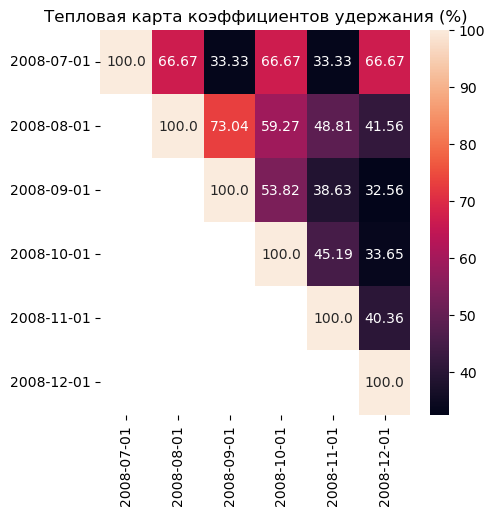

In [30]:
# Строим тепловую карту.
# Создаем таблицу.
retention = retention_rate.pivot(index='cohort_dt', columns='session_date', values='retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

# Строим хитмэп.
plt.figure(figsize=(5, 5))
sns.heatmap(retention,
           annot=True,
           fmt='')
plt.title('Тепловая карта коэффициентов удержания (%)')
plt.show()

**Вывод**

В первой когорте коэффициент удержания третьего, а затем и пятого дня показывает неожиданный рост. Данная аномалия может быть связана с технической ошибкой отнесения пользователей к неверной когорте (например, дата их регистрации как пользователей в действительности более поздняя). Мы видели подобную аномалию ранее. В то же время размер первой когорты несущественный (3 человека), а значит - данная выборка не годится для выводов по динамике коэффициента удержания.

## Анализ динамики ежемесячного количества постов

Построим таблицу, демонстрирующую, на сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

In [31]:
query = '''
WITH count AS (SELECT EXTRACT(MONTH FROM creation_date::date)::int AS creation_month,
                                         COUNT(id) AS posts_count
               FROM stackoverflow.posts
               WHERE DATE_TRUNC('day', creation_date)::date BETWEEN '2008-09-01' AND 
                                                                         '2008-12-31'
               GROUP BY 1)
SELECT *,
       ROUND(posts_count*100.0/LAG(posts_count) OVER (ORDER BY creation_month) - 100,2)
FROM count;
'''

In [32]:
dynamic = pd.read_sql_query(query, con=engine)

In [33]:
display(dynamic)

,creation_month,posts_count,round
0,9,70371,NaN
1,10,63102,-10.33
2,11,46975,-25.56
3,12,44592,-5.07


2. Построим круговую диаграмму с количеством постов по месяцам.

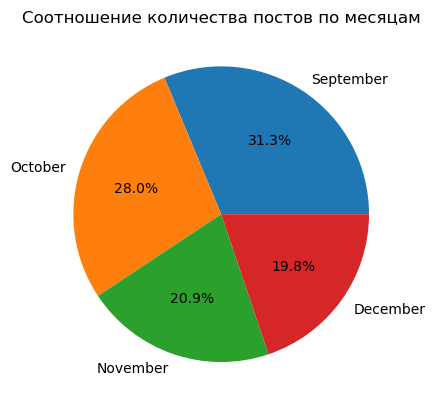

In [34]:
# Построим круговую диаграмму с количеством постов по месяцам.

labels = 'September', 'October', 'November', 'December'
fig, ax = plt.subplots()
plt.title('Соотношение количества постов по месяцам')
ax.pie(dynamic['posts_count'], labels=labels, autopct='%1.1f%%')
plt.show()

**Вывод**:

Количество опубликованных постов снижается с течением времени. Наибольшая доля постов приходится на сентябрь (31.3%), на декабрь приходится 19.8% всех рассматриваемых публикаций.

## Выгрузка данных взаимодействия с платформой за октябрь самого активного пользователя

Выгрузим данные активности пользователя, который опубликовал больше всего постов за всё время. Выведем данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

In [35]:
query = '''
WITH u AS (SELECT user_id,
                  COUNT (id)
              FROM stackoverflow.posts
              GROUP BY 1
              ORDER BY 2 DESC
              LIMIT 1),
weeks AS (SELECT EXTRACT(WEEK FROM creation_date::date) AS week_creation,
                 creation_date   
          FROM stackoverflow.posts p
          JOIN u ON u.user_id = p.user_id)
SELECT DISTINCT week_creation,
       LAST_VALUE(creation_date) OVER (PARTITION BY week_creation)
FROM weeks
WHERE DATE_TRUNC('day', creation_date)::date BETWEEN '2008-10-01' AND '2008-10-31'
ORDER BY 1;
'''

In [36]:
user = pd.read_sql_query(query, con=engine)

In [37]:
display(user)

,week_creation,last_value
0,40.0,2008-10-05 09:00:58
1,41.0,2008-10-12 21:22:23
2,42.0,2008-10-19 06:49:30
3,43.0,2008-10-26 21:44:36
4,44.0,2008-10-31 20:22:25


## Выводы

Мы написали ряд запросов к базе данных StackOverflow с целью демонстрации выгрузки заданных таблиц, анализа, поиска аномалий в данных. Результаты позволили сделать нам следующие выводы:

- Наибольшее количество просмотров постов приходится на сентябрь, постепенно снижаясь к декабрю. Вероятно, пользователи платформы - молодые люди, чье начало учебного года приходится на сентябрь, что означает взлет коммуникаций по различным учебным вопросам. Кроме того, минимальное количество приходится на летние месяцы июль и август, что также может быть связано с отпусками и снижением активности в Интернете. К декабрю просмотры падают - идет подготовка к праздникам.

- Количество опубликованных постов снижается с течением времени. Наибольшая доля постов приходится на сентябрь (31.3%), на декабрь приходится 19.8% всех рассматриваемых публикаций.

- За первую неделю декабря 2008 года пользователи тратили в среднем лишь 2 дня на активность на платформе. Учитывая приближающиеся новогодние праздники, пользователи могли больше времени проводить оффлайн, заканчивая дела в уходящем году.

- Если говорить об аномалиях, то несколько постов (32) принадлежат пользователям, зарегистрированным в сентябре, однако написали посты они в августе. Очевидно, присутствует аномалия в данных, имеющая техническую природу. Количество обнаруженных выше ошибок несущественно для анализа.

- Что касается имен пользователей, то такие, как Brian, Alan, Chris и другие, являются частоупотребимыми и не могут служить подходящим вариантов для идентикации уникальных пользователей, в отличие от id пользователей.

- По итогам расчета месячных коэффициентов удержания, в первой когорте коэффициент третьего, а затем и пятого дня показывает неожиданный рост. Данная аномалия может быть связана с технической ошибкой отнесения пользователей к неверной когорте (например, дата их регистрации как пользователей в действительности более поздняя). Мы видели подобную аномалию ранее. В то же время, размер первой когорты несущественный (3 человека), а значит - данная выборка не годится для выводов по динамике коэффициента удержания.